# Set-up & Initializations

In [2]:
#We will make a basic CNN model to classify CIFAR-100#
#We will use Keras from Tensorflow to build the model#

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import datetime

#show the tensorflow version
print(tf.__version__)


2.10.1


In [37]:
#Test if have GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17058051714305994739
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5713690624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8200012675392855988
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Train-Test split

In [38]:
#load the CIFAR-100 dataset & split into train and test sets
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

#Normalize pixel values from 1-255 to 0-1
x_train, x_test = x_train / 255.0, x_test / 255.0

#show the shape of the dataset
print("x_train= ", x_train.shape)
print("y_train= ", y_train.shape)
print("x_test= ", x_test.shape)
print("y_test= ", y_test.shape)

#Each class has 500 samples in the training set. We will delete 10% of the samples (50) from each class
#Delete 10% of each of the training set but equally from each class
#Get the number of classes
num_classes = len(np.unique(y_train))

#Get the number of samples in each class
num_samples = x_train.shape[0] / num_classes

#Get the number of samples to delete from each class
num_samples_delete = int(num_samples * 0.1)

#Get the indices of the samples to delete
indices = []

for i in range(num_classes):
    indices.append(np.where(y_train == i)[0][:num_samples_delete])

indices = np.concatenate(indices)

#Delete the samples
x_train_uniform = np.delete(x_train, indices, axis=0)
y_train_uniform = np.delete(y_train, indices, axis=0)

#show the shape of the dataset
print("x_train_uniform= ", x_train_uniform.shape)
print("y_train_uniform= ", y_train_uniform.shape)
#show how many train data is there for each class
unique, counts = np.unique(y_train_uniform, return_counts=True)
print(dict(zip(unique, counts)))


#Another set of training data will be created by deleting 20% of the first 50 classes
#Get the number of samples to delete from each class
num_samples_delete = int(num_samples * 0.2)

#Get the indices of the samples to delete
indices = []

for i in range(50):
    indices.append(np.where(y_train == i)[0][:num_samples_delete])

indices = np.concatenate(indices)

#Delete the samples
x_train_half = np.delete(x_train, indices, axis=0)
y_train_half = np.delete(y_train, indices, axis=0)

#show the shape of the dataset
print("x_train_half= ", x_train_half.shape)
print("y_train_half= ", y_train_half.shape)

#show how many train data is there for each class
unique, counts = np.unique(y_train_half, return_counts=True)
print(dict(zip(unique, counts)))




x_train=  (50000, 32, 32, 3)
y_train=  (50000, 1)
x_test=  (10000, 32, 32, 3)
y_test=  (10000, 1)
x_train_uniform=  (45000, 32, 32, 3)
y_train_uniform=  (45000, 1)
{0: 450, 1: 450, 2: 450, 3: 450, 4: 450, 5: 450, 6: 450, 7: 450, 8: 450, 9: 450, 10: 450, 11: 450, 12: 450, 13: 450, 14: 450, 15: 450, 16: 450, 17: 450, 18: 450, 19: 450, 20: 450, 21: 450, 22: 450, 23: 450, 24: 450, 25: 450, 26: 450, 27: 450, 28: 450, 29: 450, 30: 450, 31: 450, 32: 450, 33: 450, 34: 450, 35: 450, 36: 450, 37: 450, 38: 450, 39: 450, 40: 450, 41: 450, 42: 450, 43: 450, 44: 450, 45: 450, 46: 450, 47: 450, 48: 450, 49: 450, 50: 450, 51: 450, 52: 450, 53: 450, 54: 450, 55: 450, 56: 450, 57: 450, 58: 450, 59: 450, 60: 450, 61: 450, 62: 450, 63: 450, 64: 450, 65: 450, 66: 450, 67: 450, 68: 450, 69: 450, 70: 450, 71: 450, 72: 450, 73: 450, 74: 450, 75: 450, 76: 450, 77: 450, 78: 450, 79: 450, 80: 450, 81: 450, 82: 450, 83: 450, 84: 450, 85: 450, 86: 450, 87: 450, 88: 450, 89: 450, 90: 450, 91: 450, 92: 450, 93: 450,

In [39]:
#shuffle train & test data

# # Assuming x_train and y_train are your data
# indices = np.arange(x_train.shape[0])
# np.random.shuffle(indices)

# # Let's say we want to select 10000 random samples
# x_train_subset = x_train[indices[:10000]]
# y_train_subset = y_train[indices[:10000]]

## Model Training

In [40]:
#Build model for uniform train data (train_uniform)

model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model.add(Flatten())
model.add(Dense(256, activation='relu'))

# Block 5
model.add(Dense(100, activation='softmax'))

# Print the model summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 8, 8, 128)        

In [42]:
#define other models with same architecture
model2 = tf.keras.models.clone_model(model)
model2.set_weights(model.get_weights())
model2.summary()

model1_ls = tf.keras.models.clone_model(model)
model1_ls.set_weights(model.get_weights())
model1_ls.summary()

model2_ls = tf.keras.models.clone_model(model)
model2_ls.set_weights(model.get_weights())
model2_ls.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 8, 8, 128)        

### Model1 (Uniform Distribution of Train Data) without Label Smoothing

In [43]:
#Compile the model without Label Smoothing
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Train the model
log_dir = "logs/fit/" + "Model1" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train_uniform, y_train_uniform, epochs=40, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])
#save loss & validation loss every 
train_loss = history.history['loss']
val_loss = history.history['val_loss']



Epoch 1/40


c:\Users\MSI\anaconda3\envs\tf\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1407/1407 [==============================] - 9s 6ms/step - loss: 4.0223 - accuracy: 0.0717 - val_loss: 3.6548 - val_accuracy: 0.1350
Epoch 2/40
1407/1407 [==============================] - 9s 6ms/step - loss: 3.3624 - accuracy: 0.1767 - val_loss: 3.1921 - val_accuracy: 0.2148
Epoch 3/40
1407/1407 [==============================] - 9s 6ms/step - loss: 2.9776 - accuracy: 0.2501 - val_loss: 2.8933 - val_accuracy: 0.2725
Epoch 4/40
1407/1407 [==============================] - 9s 6ms/step - loss: 2.6838 - accuracy: 0.3104 - val_loss: 2.7002 - val_accuracy: 0.3092
Epoch 5/40
1407/1407 [==============================] - 8s 6ms/step - loss: 2.4512 - accuracy: 0.3571 - val_loss: 2.6097 - val_accuracy: 0.3328
Epoch 6/40
1407/1407 [==============================] - 8s 6ms/step - loss: 2.2662 - accuracy: 0.3979 - val_loss: 2.5533 - val_accuracy: 0.3440
Epoch 7/40
1407/1407 [==============================] - 9s 6ms/step - loss: 2.0938 - accuracy: 0.4341 - val_loss: 2.5378 - val_accuracy: 0.3548
Epo

### Model1 with Label Smoothing

In [44]:
#Compile the Model1 with Label Smoothing
model1_ls.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
              metrics=['accuracy'])

#Train the model
log_dir = "logs/fit/" + "Model1_LS" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train_uniform)
y_test_one_hot = tf.keras.utils.to_categorical(y_test)

history_ls = model1_ls.fit(x_train_uniform, y_train_one_hot, epochs=40, validation_data=(x_test, y_test_one_hot), callbacks=[tensorboard_callback])

#save loss & validation loss every 
train_loss_ls = history_ls.history['loss']
val_loss_ls = history_ls.history['val_loss']

Epoch 1/40


c:\Users\MSI\anaconda3\envs\tf\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1407/1407 [==============================] - 9s 6ms/step - loss: 4.1756 - accuracy: 0.0669 - val_loss: 3.8359 - val_accuracy: 0.1337
Epoch 2/40
1407/1407 [==============================] - 8s 6ms/step - loss: 3.6354 - accuracy: 0.1778 - val_loss: 3.4486 - val_accuracy: 0.2254
Epoch 3/40
1407/1407 [==============================] - 8s 6ms/step - loss: 3.3135 - accuracy: 0.2541 - val_loss: 3.2408 - val_accuracy: 0.2736
Epoch 4/40
1407/1407 [==============================] - 8s 6ms/step - loss: 3.0821 - accuracy: 0.3100 - val_loss: 3.0902 - val_accuracy: 0.3064
Epoch 5/40
1407/1407 [==============================] - 8s 6ms/step - loss: 2.9030 - accuracy: 0.3552 - val_loss: 3.0199 - val_accuracy: 0.3248
Epoch 6/40
1407/1407 [==============================] - 8s 6ms/step - loss: 2.7570 - accuracy: 0.3982 - val_loss: 2.9588 - val_accuracy: 0.3504
Epoch 7/40
1407/1407 [==============================] - 8s 6ms/step - loss: 2.6299 - accuracy: 0.4323 - val_loss: 2.9340 - val_accuracy: 0.3581
Epo

### Model2 (The first half of the classes of Train Data reduced) without Label Smoothing

In [45]:
#Comple the model2 without Label Smoothing
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Train the model2 
log_dir = "logs/fit/" + "Model2" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history2 = model2.fit(x_train_half, y_train_half, epochs=40, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])
#save loss & validation loss every
train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

Epoch 1/40


c:\Users\MSI\anaconda3\envs\tf\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1407/1407 [==============================] - 9s 6ms/step - loss: 4.0525 - accuracy: 0.0682 - val_loss: 3.7107 - val_accuracy: 0.1217
Epoch 2/40
1407/1407 [==============================] - 8s 6ms/step - loss: 3.4061 - accuracy: 0.1718 - val_loss: 3.2405 - val_accuracy: 0.2064
Epoch 3/40
1407/1407 [==============================] - 8s 6ms/step - loss: 3.0296 - accuracy: 0.2423 - val_loss: 3.0185 - val_accuracy: 0.2541
Epoch 4/40
1407/1407 [==============================] - 8s 6ms/step - loss: 2.7552 - accuracy: 0.2960 - val_loss: 2.8451 - val_accuracy: 0.2962
Epoch 5/40
1407/1407 [==============================] - 8s 6ms/step - loss: 2.5327 - accuracy: 0.3441 - val_loss: 2.7223 - val_accuracy: 0.3127
Epoch 6/40
1407/1407 [==============================] - 8s 6ms/step - loss: 2.3404 - accuracy: 0.3802 - val_loss: 2.6850 - val_accuracy: 0.3283
Epoch 7/40
1407/1407 [==============================] - 8s 6ms/step - loss: 2.1730 - accuracy: 0.4152 - val_loss: 2.5812 - val_accuracy: 0.3530
Epo

### Model2 with Label Smoothing

In [46]:
#Comple the model2 with Label Smoothing
model2_ls.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
              metrics=['accuracy'])

#Train the model2
log_dir = "logs/fit/" + "Model2_LS" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train_half)
y_test_one_hot = tf.keras.utils.to_categorical(y_test)

history2_ls = model2_ls.fit(x_train_half, y_train_one_hot, epochs=40, validation_data=(x_test, y_test_one_hot), callbacks=[tensorboard_callback])

#save loss & validation loss every
train_loss2_ls = history2_ls.history['loss']
val_loss2_ls = history2_ls.history['val_loss']

Epoch 1/40
1407/1407 [==============================] - 11s 7ms/step - loss: 4.1526 - accuracy: 0.0694 - val_loss: 3.8379 - val_accuracy: 0.1333
Epoch 2/40
1407/1407 [==============================] - 8s 6ms/step - loss: 3.5591 - accuracy: 0.1916 - val_loss: 3.3959 - val_accuracy: 0.2308
Epoch 3/40
1407/1407 [==============================] - 8s 6ms/step - loss: 3.2161 - accuracy: 0.2737 - val_loss: 3.1721 - val_accuracy: 0.2878
Epoch 4/40
1407/1407 [==============================] - 8s 6ms/step - loss: 2.9827 - accuracy: 0.3360 - val_loss: 3.0789 - val_accuracy: 0.3171
Epoch 5/40
1407/1407 [==============================] - 8s 6ms/step - loss: 2.8127 - accuracy: 0.3798 - val_loss: 2.9612 - val_accuracy: 0.3466
Epoch 6/40
1407/1407 [==============================] - 8s 6ms/step - loss: 2.6654 - accuracy: 0.4195 - val_loss: 2.9355 - val_accuracy: 0.3561
Epoch 7/40
1407/1407 [==============================] - 9s 6ms/step - loss: 2.5320 - accuracy: 0.4590 - val_loss: 2.8883 - val_accuracy

## Evaluation

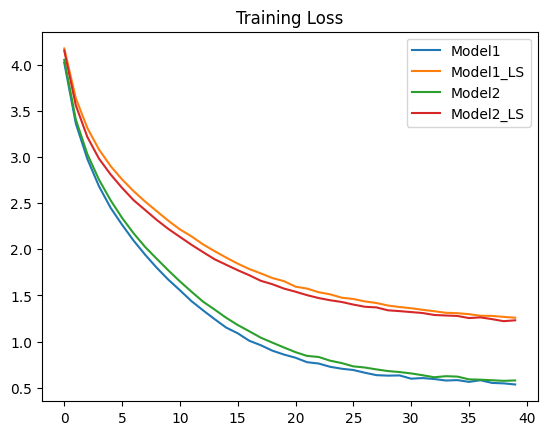

In [47]:

#Plot the loss
plt.figure()
plt.plot(train_loss, label='Model1')
plt.plot(train_loss_ls, label='Model1_LS')
plt.plot(train_loss2, label='Model2')
plt.plot(train_loss2_ls, label='Model2_LS')
plt.title('Training Loss')
plt.legend()
plt.show()


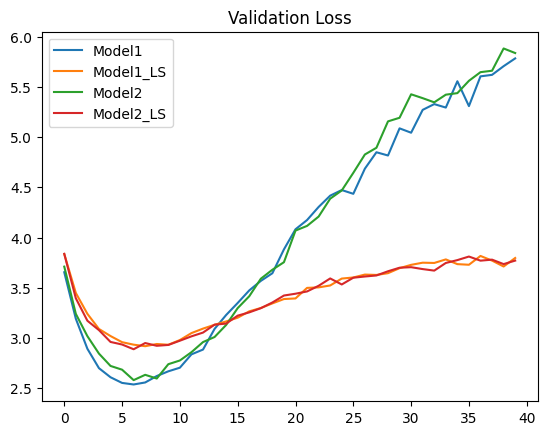

In [48]:
#Plot the validation accuracy of the models
plt.figure()
plt.plot(val_loss, label='Model1')
plt.plot(val_loss_ls, label='Model1_LS')
plt.plot(val_loss2, label='Model2')
plt.plot(val_loss2_ls, label='Model2_LS')
plt.title('Validation Loss')
plt.legend()
plt.show()



In [13]:
#plot the accuracy (train accuracy and validation accuracy) of the models
# plt.figure()
# plt.plot(history.history['accuracy'], label='Model1')
# plt.plot(history_ls.history['accuracy'], label='Model1_LS')
# plt.plot(history2.history['accuracy'], label='Model2')

# plt.plot(history2_ls.history['accuracy'], label='Model2_LS')
# plt.title('Model accuracy')
# plt.legend()
# plt.show()

# #plot the validation accuracy of the models
# plt.figure()
# plt.plot(history.history['val_accuracy'], label='Model1')
# plt.plot(history_ls.history['val_accuracy'], label='Model1_LS')
# plt.plot(history2.history['val_accuracy'], label='Model2')

# plt.plot(history2_ls.history['val_accuracy'], label='Model2_LS')
# plt.title('Model validation accuracy')
# plt.legend()
# plt.show()

#show the maximum accuracies for each models
print("Model1: ", max(history['val_accuracy']))
print("Model1_LS: ", max(history_ls['val_accuracy']))
print("Model2: ", max(history2['val_accuracy']))
print("Model2_LS: ", max(history2_ls['val_accuracy']))



Model1:  0.3698999881744385
Model1_LS:  0.37610000371932983
Model2:  0.35929998755455017
Model2_LS:  0.37950000166893005


## Save the trained Model

In [50]:
#save the trained model (Parameters) so I can use it again without training again
model.save('model.h5')
model1_ls.save('model1_ls.h5')
model2.save('model2.h5')
model2_ls.save('model2_ls.h5')

#save the histories
np.save('history.npy', history.history)
np.save('history_ls.npy', history_ls.history)
np.save('history2.npy', history2.history)
np.save('history2_ls.npy', history2_ls.history)



## Load the trained Model

In [4]:
#load the model
# model = tf.keras.models.load_model('model.h5')
# model1_ls = tf.keras.models.load_model('model1_ls.h5')
# model2 = tf.keras.models.load_model('model2.h5')
# model2_ls = tf.keras.models.load_model('model2_ls.h5')

#load the histories
history = np.load('history.npy', allow_pickle='TRUE').item()
history_ls = np.load('history_ls.npy', allow_pickle='TRUE').item()
history2 = np.load('history2.npy', allow_pickle='TRUE').item()
history2_ls = np.load('history2_ls.npy', allow_pickle='TRUE').item()
